In [1]:
# jupyter里加上这一行可以让图像正常显示，防止部分情况报错
%matplotlib inline

# 加上这两行可以一次性输出多个变量而不用print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#忽略任何报错信息
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd 
import os 
import datetime
import matplotlib.pyplot as plt

In [4]:
# 文件路径，这里使用绝对路径，如果是打包的project，最好在同一个dir之下使用相对路径
file_path_child = r'D:\\xinanshuji\\CFPS\\CFPS-data\\cfps2018childproxy_202012.dta'
file_path_famconf = r'D:\\xinanshuji\\CFPS\\CFPS-data\\ecfps2018famconf_202008.dta'
file_path_famecon = r'D:\\xinanshuji\\CFPS\\CFPS-data\\ecfps2018famecon_202101.dta'
file_path_person = r'D:\\xinanshuji\\CFPS\\CFPS-data\\ecfps2018person_202012.dta'
file_path_cross = r'D:\\xinanshuji\\CFPS\\CFPS-data\\ecfps2018crossyearid_202104.dta'

In [5]:
data_famecon = pd.read_stata(file_path_famecon, convert_categoricals=False) 
data_famconf = pd.read_stata(file_path_famconf, convert_categoricals=False) 
data_cross = pd.read_stata(file_path_cross, convert_categoricals=False) 
data_person = pd.read_stata(file_path_person, convert_categoricals=False) 

# 先处理分析家庭关系表 data_famconf
## 列出一些变量
- id related
    - pid: 个人样本编码； 用于匹配
    - fid18 : 家庭id； 用于匹配
    - fid10 fid12 fid14 fid16 : 往次调查的家庭id
    - code_a_p： 个人户内代码，可以用于剔除同住但无直接血缘关系的人 
    - code_a18_p: 个人是否与该家庭在经济上是一家人


- 基因成员: genetype18（有细分）  gene
- 是否核心成员：COREMEMBER18

- 性别：tb2_a_p
- 出生年、月：tb1y_a_p, tb1m_a_p ;  调查年、月：cyear18, cmonth18  用于计算访问时的年龄
- 户口：hukou_a18_p
- 个人婚姻：tb3_a18_p
    - 配偶婚姻：tb3_a18_s
    - 配偶户口：hukou_a18_s
    - 配偶是否健在：alive_a18_s
    - 配偶去世原因：ta401_a18_s
- 个人问卷是否完成：cfps2018_interv_p
- 个人是否健在：alive_a18_p
- 个人去世原因：ta401_a18_p
    - 意外死亡代码：17
        - 17.0.70	机动车辆交通事故， 17.0.71	机动车以外的运输事故， 17.0.73	意外跌落，17.0.76	淹死

- 父母信息
    - pid_a_f: 父亲样本编码
    - TB6_A18_F：父亲是否居住在家
    - TB1Y_A_F：父亲出生年， TB1M_A_F:出生月
    - TA4Y_A18_F：父亲去世年份， TA4M_A18_F: 父亲去世月份
    - TA401_A18_F：去世原因
- 母亲信息
    - pid_a_m
    
    
- 子女信息
    - pid_a_c1-10：孩子样本编码
    - TB2_A_C1-10: 孩子性别
    
    
- 访问形式：iwmode18

In [6]:
data_famecon['fid18'].describe()
data_famecon['fid18'].value_counts()

count    1.421800e+04
mean     4.014819e+05
std      3.167562e+05
min      1.000510e+05
25%      2.297105e+05
50%      4.105525e+05
75%      5.200708e+05
max      6.759191e+06
Name: fid18, dtype: float64

100051.0     1
441959.0     1
441946.0     1
441947.0     1
441949.0     1
            ..
311715.0     1
311716.0     1
311717.0     1
311718.0     1
6759191.0    1
Name: fid18, Length: 14218, dtype: int64

In [7]:
data_famconf = pd.read_stata(file_path_famconf, convert_categoricals=False) 
data_famconf['fid18'].describe()
data_famconf['fid18'].value_counts()

count    5.850400e+04
mean     4.056989e+05
std      2.575733e+05
min      1.000510e+05
25%      2.569400e+05
50%      4.112700e+05
75%      5.200062e+05
max      6.817001e+06
Name: fid18, dtype: float64

510398.0     21
441105.0     17
510395.0     16
441709.0     16
440264.0     15
             ..
205249.0      1
205826.0      1
620443.0      1
311545.0      1
5753002.0     1
Name: fid18, Length: 15051, dtype: int64

In [8]:
#以下部分选择基因成员和核心成员进行分析
famconf = data_famconf[(data_famconf['gene']==1) | (data_famconf['coremember18']==1)]
famconf.shape

(55793, 296)

In [9]:
# check data
print(famconf['tb1m_a_p'].describe())  # 月份
print(famconf['tb1y_a_p'].describe())  # 年份
# -9 为缺失值

count    55793.000000
mean         6.394619
std          3.949687
min         -9.000000
25%          3.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: tb1m_a_p, dtype: float64
count    55793.000000
mean      1972.925618
std        116.467357
min         -9.000000
25%       1963.000000
50%       1981.000000
75%       1996.000000
max       2018.000000
Name: tb1y_a_p, dtype: float64


In [10]:
print('月缺失数据：', famconf[famconf['tb1m_a_p']==-9].shape[0])
print('年缺失数据： ',famconf[famconf['tb1y_a_p']==-9].shape[0])
print('年缺失数据： ',famconf[famconf['tb1y_a_p']==-1].shape[0])  # check codebook, 年份有 -1（不知道）， -9
# 处理方法，剔除年缺失数据，月缺失数据补充月份为 6 

月缺失数据： 877
年缺失数据：  180
年缺失数据：  5


In [11]:
# famconf.loc[:,['tb1y_a_p','tb1m_a_p']]
print(famconf['tb1m_a_p'].value_counts())

 10.0    5503
 9.0     4889
 8.0     4762
 11.0    4645
 12.0    4617
 3.0     4529
 2.0     4448
 1.0     4430
 7.0     4357
 5.0     4322
 4.0     4232
 6.0     4182
-9.0      877
Name: tb1m_a_p, dtype: int64


In [12]:
# 出生年、月：tb1y_a_p, tb1m_a_p ;  调查年、月：cyear18, cmonth18  用于计算访问时的年龄
# 1. 合并年月
def combine_date(x):
#     print(x[0])
#     print(x[1])
#    print(str(x[0]).split('.')[0]+str(x[1]).split('.')[0])
    if (x[0] == -9) | (x[0] == -1):  # 剔除年份缺失数据
        return None
    else:
        if x[1] == -9:  # 月份缺失数据填 6 月
            return str(x[0]).split('.')[0]+'6'
        return str(x[0]).split('.')[0]+str(x[1]).split('.')[0]

famconf['birthday']=famconf[['tb1y_a_p','tb1m_a_p']].apply(combine_date,axis=1)
famconf['visitday']=famconf[['cyear18','cmonth18']].apply(combine_date,axis =1)

In [13]:
# famconf.loc[:,['birthday']]
print(famconf['birthday'].value_counts())

19876     141
19634     136
198810    130
19902     127
198910    127
         ... 
19264       1
19187       1
19221       1
19178       1
192012      1
Name: birthday, Length: 1175, dtype: int64


In [14]:
# 2. 转换为 datetime 格式
famconf['birthday_dt']=pd.to_datetime(famconf['birthday'],format='%Y%m')
famconf['visitday_dt']=pd.to_datetime(famconf['visitday'],format='%Y%m')

In [15]:
# 计算年龄 用调查时间 - 出生日期
famconf['age']=(famconf['visitday_dt']-famconf['birthday_dt']).dt.days/365 

In [16]:
fam = famconf['fid18'].duplicated()
fam_num = famconf['age'].mean()

<AxesSubplot:>

Text(0.5, 1.0, '年龄分布')

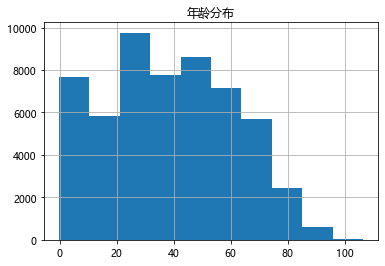

In [17]:
# 中文乱码和坐标轴负号的处理
#字体设为微软雅黑
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

famconf['age'].hist()
plt.title('年龄分布')
#下面这行取消注释可以保存图表，但是需要自己修改地址，最好设为绝对路径，后面同理
# plt.savefig('ages.png')

In [18]:
#通过numpy库进行数据计算的操作
import numpy as np
#数据聚合操作，把同一个家庭的人放在一起
# grouped=famconf['age'].groupby(by=famconf['fid18']).agg(np.mean)
grouped=famconf['age'].groupby(by=famconf['fid18']).agg([
        ('age_mean', np.mean)
        ])
grouped.reset_index(inplace=True)

In [19]:
grouped

,fid18,age_mean
0,100051.0,42.137900
1,100160.0,28.267123
2,100286.0,39.778082
3,100376.0,21.968493
4,100435.0,17.260959
...,...,...
15041,6646971.0,22.828767
15042,6694541.0,23.098630
15043,6704011.0,22.432877
15044,6759191.0,25.890411


In [20]:
#数据分桶，即把年龄分成'0-16','16-22','23-45','46-60','60+'这五个类型
age_cut = [-1, 16, 23,46,60,120]
age_seg = pd.cut(grouped['age_mean'],bins = age_cut,labels=['0-16','16-22','23-45','46-60','60+'])
grouped['age_segment']= age_seg.values
a = grouped['age_segment'].value_counts()
a

23-45    8608
46-60    2501
60+      2378
16-22    1305
0-16      253
Name: age_segment, dtype: int64

<Figure size 1164.96x720 with 0 Axes>

<BarContainer object of 5 artists>

Text(0.5, 1.0, '家庭平均年龄分布')

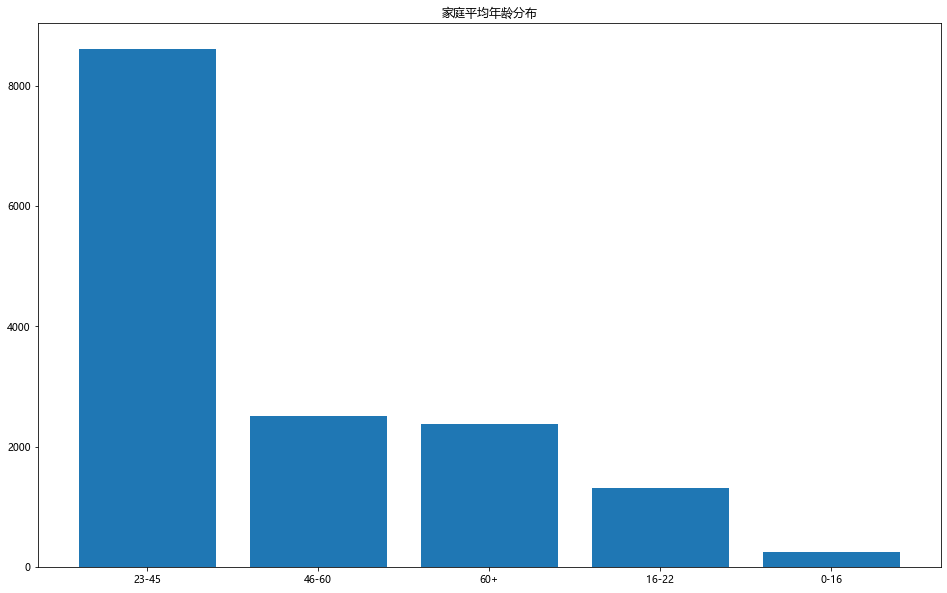

In [21]:
plt.figure(figsize=(16.18,10))
plt.bar(a.index, a.values)
plt.title('家庭平均年龄分布')
plt.show()
# plt.savefig('ages.png')

### 至此，对家庭分年龄段的操作已经解决了

- finance
    - fn3: 是否领取离退休或养老金； fn301 领取离退休或养老金总额（元）
    - fn401: 子女给的钱（元）（不同住子女）
    - FN4	亲戚给的钱（元）
    - FN5	其他人给的钱（元）

  
    - fp510 教育培训支出
    - FQ2 房屋归谁所有
        1：家庭成员有完全产权
        2： 部分产权
        3： 单位提供的房子
        4：廉租房； 5： 公租房；6：租的商品房； 7：亲戚、朋友的房子
    - FQ6 房子当前市价
        - FQ6_MAX： 当前市价最大值
        - FQ_MIN: 最小值
    - FR1： 是否还有房产
        - FR101：还有几处房产
        - FR2： 其它房产市价总价
        - FR2_MAX, FR2_MIN, FR2_EST
        
    - FS6V: 耐用品消费总值（元）
    
    - 金融资产
        - FT1：现金及存款总额（元）
            - FT1_MAX, FT1_MIN, FT1_EST
            - FT101: 定期存款总额
            
        - FT200：是否持有金融产品
            - FT201： 金融产品总价
            
    - 负债：
        - FT3： 是否贷款买房或装修
            - FT301： 待偿房贷本息总额（万元）
        - FT4	是否购房建房装修借款
            - FT401	购房建房装修借款额度（元）
        - FT5	待偿银行贷款（除房贷） 是否
            - FT501	您家待偿贷款额（元）
        - FT6 待偿亲友借款 是否
            -  FT601 您家待偿亲友借款（元）
	
    - FAMILYSIZE18: 家庭人口规模（综合变量）
        - fml_count 2018年家庭成员人口数 （加载的是Rtype = 1-5, 7(外出家庭成员）的成员，不包括同住（经济独立）的家庭成员
    
    - FSWT_NATCS18N：家庭横截面权数
	
	
	


In [22]:
data_famecon.shape
data_famecon.iloc[0:5,0:20]

(14218, 321)

,fid18,fid16,fid14,fid12,fid10,provcd18,countyid18,cid18,urban18,iwmode,feinterv,fml_count,pid_a_1,pid_a_2,pid_a_3,pid_a_4,pid_a_5,pid_a_6,pid_a_7,pid_a_8
0,100051.0,100051.0,100051.0,110043.0,110043.0,11.0,45.0,624942.0,1.0,2.0,1.0,3.0,100051501.0,100051502.0,110043107.0,-8.0,-8.0,-8.0,-8.0,-8.0
1,100160.0,100160.0,100160.0,120009.0,120009.0,12.0,79.0,NaN,1.0,1.0,1.0,2.0,120009102.0,100160601.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0
2,100286.0,100286.0,100286.0,130005.0,130005.0,13.0,239.0,NaN,1.0,2.0,1.0,1.0,130005103.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0
3,100435.0,100435.0,100435.0,130155.0,130155.0,13.0,52.0,121200.0,0.0,2.0,1.0,4.0,100435552.0,130155103.0,130155521.0,277731501.0,-8.0,-8.0,-8.0,-8.0
4,100453.0,100453.0,100453.0,100453.0,430111.0,43.0,29.0,533420.0,1.0,1.0,1.0,6.0,100453401.0,100453431.0,100453551.0,430111101.0,430111102.0,430111103.0,-8.0,-8.0


## 家庭资产分析
#### 资产
    - 房产 fq2 (=1,=2), fr1
        - 价值 
            - fq6, fq6_max, fq6_min
            - fr2, fr2_max, fr2_min, fr2_est
    - 耐用品
        - 消费总值：fs6v
        
    - 金融资产 FT200：是否持有金融产品
        - FT201： 金融产品总价
#### 负债
    - FT3： 是否贷款买房或装修
        - FT301： 待偿房贷本息总额（万元）
    - FT4   是否购房建房装修借款
        - FT401  购房建房装修借款额度（元）
    - FT5   待偿银行贷款（除房贷） 是否
        - FT501  您家待偿贷款额（元）
    - FT6 待偿亲友借款 是否
        -  FT601 您家待偿亲友借款（元）

In [23]:
# 进行数据集的合并，主表为famecon，辅表为处理好的grouped，这样，每个家庭的平均年龄就添加到表中了。
famecon = data_famecon.set_index('fid18')
merge1=pd.merge(left=famecon,right=grouped,on='fid18')

In [24]:
#接下来，merge1将为我们主要处理的数据集
merge1

,fid18,fid16,fid14,fid12,fid10,provcd18,countyid18,cid18,urban18,iwmode,...,subpopulation,subsample,familysize18,psu,fswt_natcs18n,interrupt,interviewerid18,releaseversion,age_mean,age_segment
0,100051.0,100051.0,100051.0,110043.0,110043.0,11.0,45.0,624942.0,1.0,2.0,...,6.0,1.0,3.0,45.0,1.181271,NaN,761040.0,2.2,42.137900,23-45
1,100160.0,100160.0,100160.0,120009.0,120009.0,12.0,79.0,NaN,1.0,1.0,...,6.0,1.0,2.0,79.0,2.306826,NaN,459505.0,2.2,28.267123,23-45
2,100286.0,100286.0,100286.0,130005.0,130005.0,13.0,239.0,NaN,1.0,2.0,...,6.0,1.0,1.0,47.0,1.985643,NaN,966285.0,2.2,39.778082,23-45
3,100435.0,100435.0,100435.0,130155.0,130155.0,13.0,52.0,121200.0,0.0,2.0,...,6.0,1.0,4.0,52.0,0.965663,NaN,771787.0,2.2,17.260959,16-22
4,100453.0,100453.0,100453.0,100453.0,430111.0,43.0,29.0,533420.0,1.0,1.0,...,6.0,1.0,6.0,29.0,2.313559,NaN,821293.0,2.2,35.828311,23-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14213,6609501.0,441838.0,441838.0,441838.0,441838.0,44.0,1985.0,501334.0,1.0,2.0,...,5.0,0.0,1.0,143.0,0.469431,NaN,223345.0,2.2,21.509589,16-22
14214,6646971.0,621344.0,621344.0,621344.0,621344.0,62.0,140.0,796912.0,1.0,2.0,...,4.0,0.0,2.0,155.0,0.129904,NaN,428499.0,2.2,22.828767,16-22
14215,6694541.0,211229.0,211229.0,211229.0,211229.0,15.0,592.0,NaN,-9.0,2.0,...,2.0,0.0,1.0,171.0,0.265240,NaN,843997.0,2.2,23.098630,23-45
14216,6704011.0,220306.0,220306.0,220306.0,220306.0,22.0,59.0,123900.0,1.0,2.0,...,6.0,1.0,1.0,59.0,1.235392,NaN,225081.0,2.2,22.432877,16-22


In [25]:
# participation rate
# 資產
merge1['housing'] = [1 if (i[1]['fq2'] == 1) or (i[1]['fq2'] == 2) or (i[1]['fr1'] == 1) else 0 for i in merge1[['fq2','fr1']].iterrows()]
merge1['durable'] = [1 if i>0 else 0 for i in merge1['fs6v'].values]
merge1['fin_asset'] = [1 if i == 1 else 0 for i in merge1['ft200'].values]
# 負債
merge1['mortgage'] = [1 if i==1 else 0 for i in merge1['ft3'].values]
merge1['bank_loan'] = [1 if i==1 else 0 for i in merge1['ft5'].values]
merge1['friend_loan'] = [1 if i == 1 else 0 for i in merge1['ft6'].values]

In [26]:
print('Participation rate')
merge1[['housing','durable','fin_asset','mortgage','bank_loan','friend_loan']].apply(lambda x: sum(x)/len(x))

Participation rate


housing        0.845196
durable        0.909833
fin_asset      0.056970
mortgage       0.116894
bank_loan      0.096146
friend_loan    0.128991
dtype: float64

In [27]:
# 不同家庭人平均年龄看一下participation rate
result = merge1[['housing','durable','fin_asset','mortgage','bank_loan','friend_loan']].groupby(merge1['age_segment']).agg(lambda x: sum(x)/len(x))

In [28]:
result

,housing,durable,fin_asset,mortgage,bank_loan,friend_loan
age_segment,,,,,,
0-16,0.695853,0.884793,0.046083,0.152074,0.156682,0.179724
16-22,0.649108,0.891249,0.050127,0.194562,0.149533,0.141886
23-45,0.858331,0.928187,0.057499,0.138243,0.116100,0.150966
46-60,0.910046,0.913409,0.065153,0.086171,0.064313,0.113913
60+,0.845815,0.852423,0.051101,0.028634,0.024229,0.054185


Text(0.5, 0, 'family average age')

Text(0, 0.5, 'participation rate')

Text(0.5, 0, 'family average age')

Text(0, 0.5, 'participation rate')

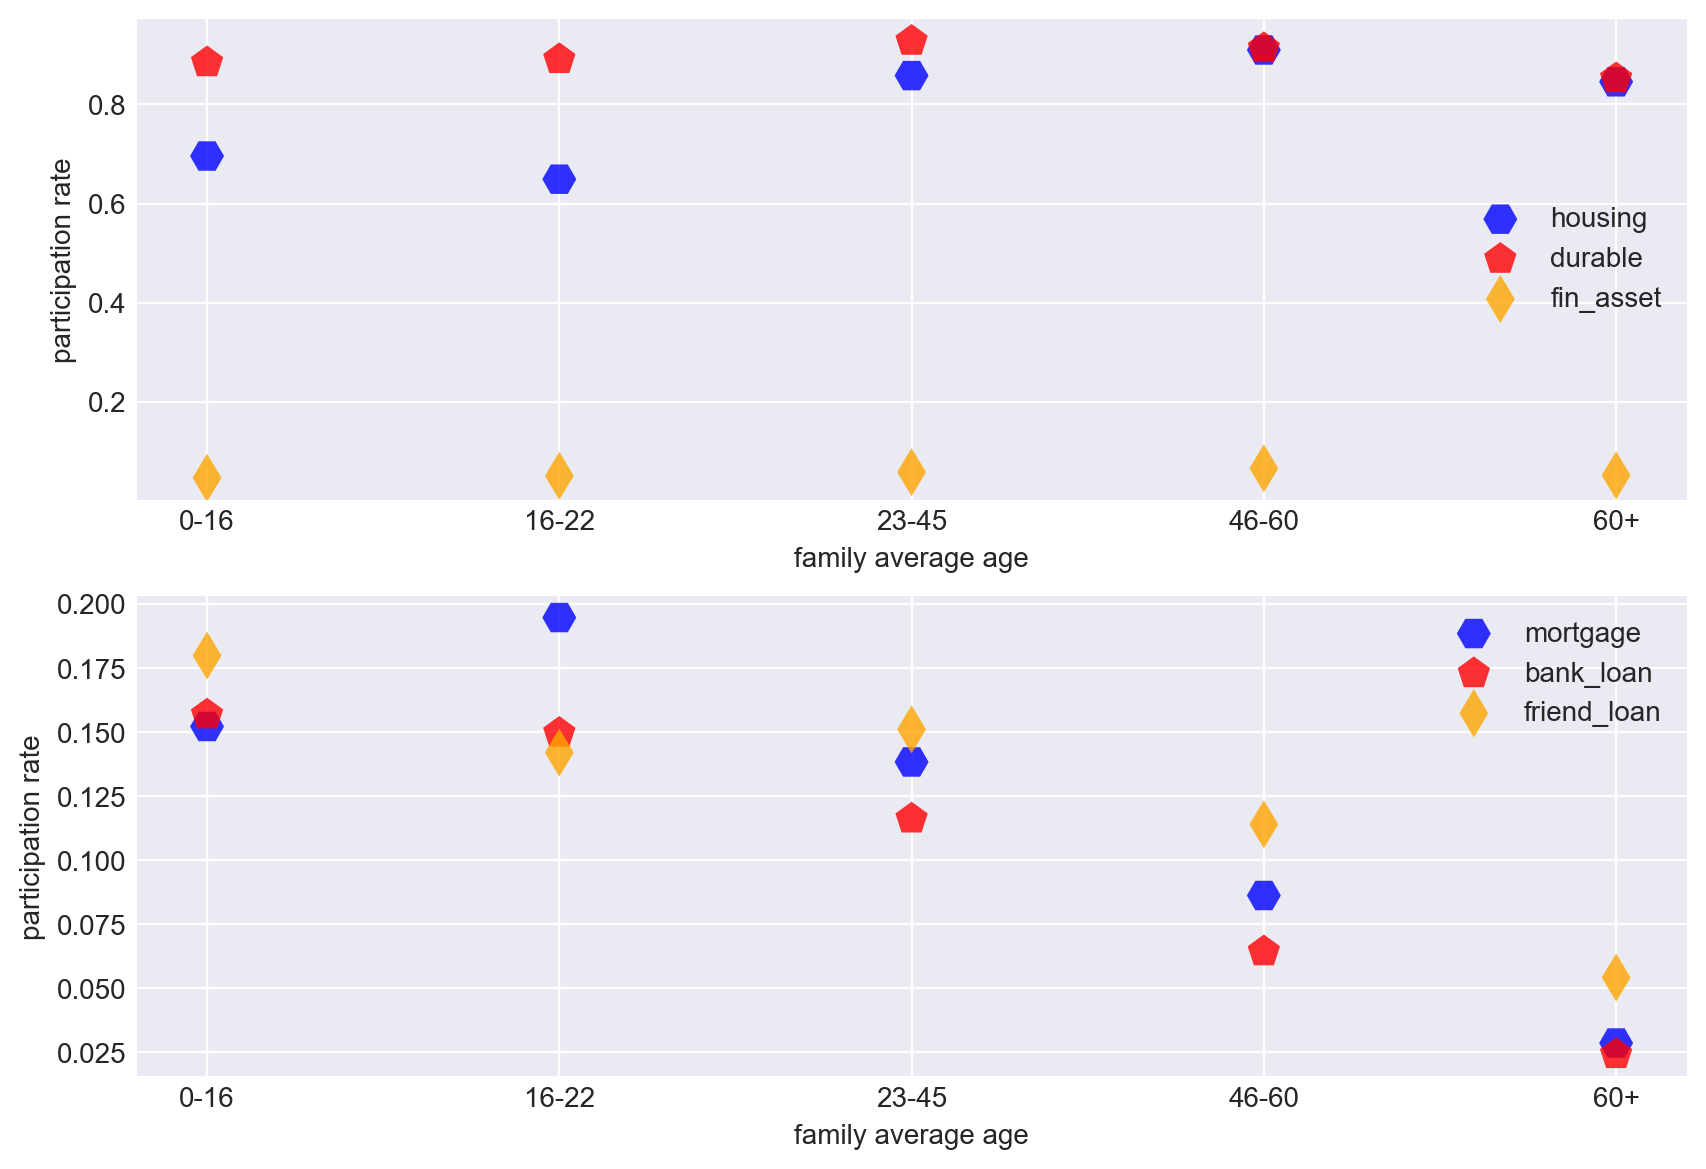

In [29]:
# 设置风格
# plt.style.use('ggplot')
# colors = ['#c72e29','#098154','#fb832d']#三种不同颜色
colors = ['blue','red','orange']
# markers = ['$\clubsuit$','.','+']#三种不同图形，都把点的形状换成了规则且明显的图形
markers = ['H','p','d']
fig = plt.figure(figsize=(10,7),dpi=200)
plt.style.use('seaborn-darkgrid')#指定风格,ggplot太丑了
# plt.scatter(result.index[0:10], result.iloc[0:10,0])
for j in [1,2]:
    ax = fig.add_subplot(2,1,j)
    for i in range(3):
        ax.scatter(result.index[0:9],#传入数据x
                   result.iloc[0:9,(j-1)*3+i],#传入数据y
                    s = 150,#散点图形（marker）的大小
                    c = colors[i],#marker颜色
                    marker = markers[i],#marker形状
                    #marker=matplotlib.markers.MarkerStyle(marker = markers[i],fillstyle='full'),#设置marker的填充
                    alpha=0.8,#marker透明度，范围为0-1
                    facecolors='r',#marker的填充颜色，当上面c参数设置了颜色，优先c
                    edgecolors='none',#marker的边缘线色
                    linewidths=1,#marker边缘线宽度，edgecolors不设置时，该参数不起作用
                    label = result.columns[(j-1)*3+i])#后面图例的名称取自label
                 
 
    plt.legend(loc = 'best')
    plt.xlabel('family average age')
    plt.ylabel("participation rate")
plt.show()
# plt.savefig('ages.png')

## 至此，家庭资产按照年龄分析已经做完了

## 下面，分析老年人资产

老年人财产来源：退休金(fn301)、子女给的钱(fn401)、亲戚给的钱(fn4)、其他人给的钱(fn5)

In [30]:
famecon.loc[:,['fn3','fn301','fn401','fn4','fn5']]

,fn3,fn301,fn401,fn4,fn5
fid18,,,,,
100051.0,5.0,-8.0,0.0,0.0,0.0
100160.0,5.0,-8.0,0.0,10000.0,0.0
100286.0,5.0,-8.0,0.0,0.0,0.0
100435.0,5.0,-8.0,0.0,0.0,0.0
100453.0,1.0,50000.0,0.0,0.0,0.0
...,...,...,...,...,...
6609501.0,5.0,-8.0,0.0,0.0,0.0
6646971.0,5.0,-8.0,0.0,0.0,0.0
6694541.0,5.0,-8.0,0.0,0.0,0.0


In [31]:
def total_assets(x):
    if (x[0]==-8):     #-8:无退休金
        return x[1]+x[2]+x[3]
    return x[0]+x[1]+x[2]+x[3]

#上面是计算老年人财产的函数，并以此计算
famecon['elderly_asset']=famecon[['fn301','fn401','fn4','fn5']].apply(total_assets,axis=1)

In [32]:
famecon['elderly_asset'].value_counts()
famecon['elderly_asset'].describe()

0.0        6577
2000.0      344
1000.0      341
10000.0     229
20000.0     220
           ... 
1505.0        1
6840.0        1
11320.0       1
18760.0       1
1099.0        1
Name: elderly_asset, Length: 1214, dtype: int64

count      14218.000000
mean       10390.715572
std        26691.787812
min           -3.000000
25%            0.000000
50%          500.000000
75%         6000.000000
max      1000000.000000
Name: elderly_asset, dtype: float64

In [33]:
#财产分段
asset_cut=[-3,3001,7001,10001,30001,70001,1000000]
asset_seg=pd.cut(famecon['elderly_asset'],bins=asset_cut,labels=['0-3000','3001-7000','7001-10000','10001-30000','30001-70000','70001+'])
famecon['asset_segment']=asset_seg.values
c=famecon['asset_segment'].value_counts()
c

0-3000         9789
10001-30000    1348
30001-70000    1101
3001-7000      1011
70001+          486
7001-10000      482
Name: asset_segment, dtype: int64

<Figure size 1164.96x720 with 0 Axes>

<BarContainer object of 6 artists>

Text(0.5, 1.0, '财产分布')

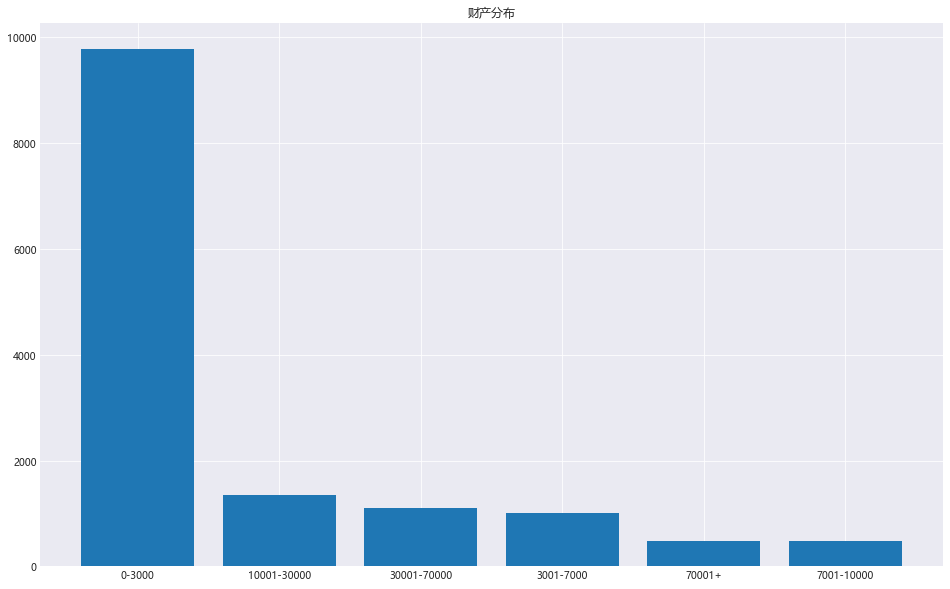

In [34]:
#防止中文乱码
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(16.18,10))
plt.bar(c.index, c.values)
plt.title('财产分布')
plt.show()

### 下面对养老金进行划分

In [35]:
famecon['fn301'].describe()

count     14218.000000
mean       7608.400338
std       20274.615214
min          -8.000000
25%          -8.000000
50%          -8.000000
75%        1800.000000
max      336000.000000
Name: fn301, dtype: float64

In [36]:
#小于零的都是缺失的数据，可见缺失的数据非常多，无法直接丢弃，那么取出所有有效值观察数据的分组，再进行空数据填充
f1=famecon[famecon.fn301>0]
f1['fn301'].describe()

count      5218.000000
mean      20745.069950
std       29112.092621
min           1.000000
25%        1260.000000
50%        3200.000000
75%       31200.000000
max      336000.000000
Name: fn301, dtype: float64

In [37]:
'''
由上所示，众数是1800，所以所有缺失的数据都以75%四分位数1800代替
理论上说，应该保证填充的数据与原数据是同分布的，但是代码过程较为繁琐
且原数据是长尾分布，1800的数量非常多，其他数据的分布形式意义不大，那么1800填充也是合理的
在下一步分组之中，填充值在0-3000之内的变化，并不会影响分组的结果
'''
famecon.fn301[famecon.fn301<0] = 1800

'\n由上所示，众数是1800，所以所有缺失的数据都以75%四分位数1800代替\n理论上说，应该保证填充的数据与原数据是同分布的，但是代码过程较为繁琐\n且原数据是长尾分布，1800的数量非常多，其他数据的分布形式意义不大，那么1800填充也是合理的\n在下一步分组之中，填充值在0-3000之内的变化，并不会影响分组的结果\n'

In [38]:
famecon['fn301'].describe()

count     14218.000000
mean       8752.832677
std       19859.139112
min           1.000000
25%        1800.000000
50%        1800.000000
75%        1800.000000
max      336000.000000
Name: fn301, dtype: float64

In [39]:
#一个手动实现养老金金额划分的函数
def split_pension(x):
    if ((x>=0) &(x<3001)):     
        return '0-3000'
    elif ((x>=3001) &(x<7001)):     
        return '3001-7000'
    elif ((x>=7001) &(x<10001)):     
        return '7001-10001'
    elif ((x>=7001) &(x<10001)):     
        return '7001-10001'
    elif ((x>=10001) &(x<30001)):     
        return '10001-30001'
    elif ((x>=30001) &(x<70001)):     
        return '30001-70001'
    elif ((x>=70001) &(x<100001)):     
        return '70001-100001'
    elif ((x>=100001)):     
        return '100001+'
famecon['split_pension']=famecon['fn301'].apply(split_pension)

In [40]:
#观察分组后的情况
a=famecon['split_pension'].value_counts()
a

0-3000          11597
10001-30001       969
30001-70001       947
70001-100001      280
3001-7000         203
7001-10001        129
100001+            93
Name: split_pension, dtype: int64

<Figure size 1164.96x720 with 0 Axes>

<BarContainer object of 7 artists>

Text(0.5, 1.0, '不同养老金的分布人数')

Text(0, 11600, '11597')

Text(1, 972, '969')

Text(2, 950, '947')

Text(3, 283, '280')

Text(4, 206, '203')

Text(5, 132, '129')

Text(6, 96, '93')

Text(0, 0.5, '人数(个)')

Text(0.5, 0, '养老金(RMB)')

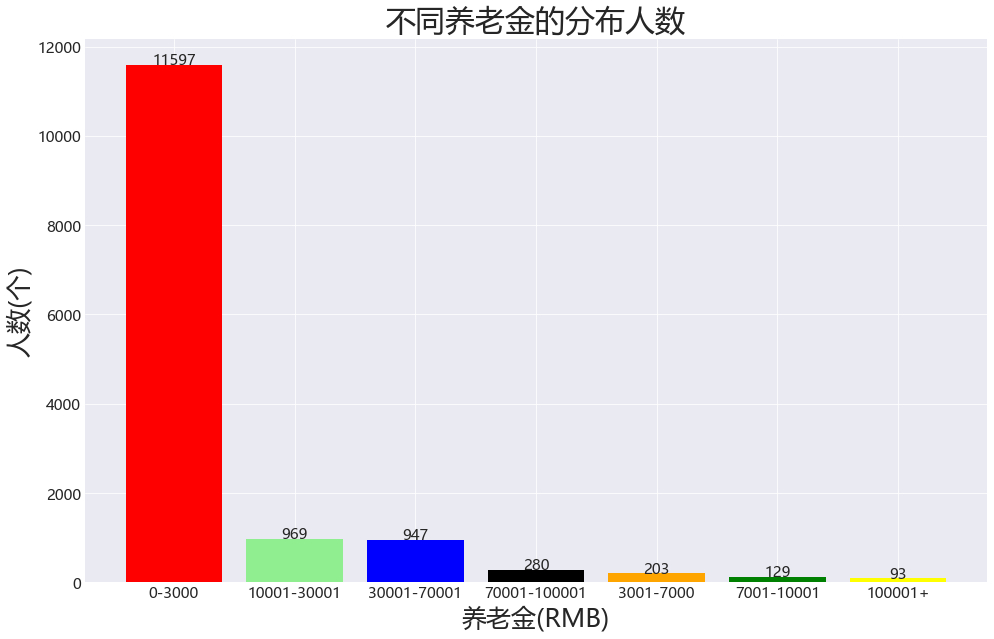

In [41]:
#画图解决问题
plt.figure(figsize=(16.18,10))
plt.bar(a.index,a.values,color=['r','lightgreen','b','black','orange','green','yellow'])
plt.title('不同养老金的分布人数',size=30)
#显示每条的具体数值
for x,y in enumerate(a.values):
    plt.text(x,y+3,"%s"%round(y,1),ha='center',size=15)
#设置坐标刻度值的大小
plt.tick_params(labelsize=15)
#设置横纵坐标
plt.ylabel("人数(个)",size=25)
plt.xlabel("养老金(RMB)",size=25)
plt.show()

### 至此，养老金维度结束

### 下面进行子女数量维度的处理

In [42]:
#采用的方法是，对pid_a_c1-10变量进行统计，如果有就加一，函数返回值为子女数量
def child_num(x):
    a=0
    for i in range(8):
        if x[i]!=-8:
            a+=1
    return a


famconf['child_num']=famconf[['pid_a_c1','pid_a_c2','pid_a_c3','pid_a_c4','pid_a_c5','pid_a_c6','pid_a_c7','pid_a_c8','pid_a_c9','pid_a_c10']].apply(child_num,axis=1)

In [43]:
#看一下子女数量的分布，现在的还是所有人的子女数量
famconf["child_num"].describe()

count    55793.000000
mean         1.227699
std          1.249945
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: child_num, dtype: float64

In [90]:
#表的连接
merge3=pd.merge(left=famecon,right=famconf[['child_num','fid18']],on='fid18')
merge3

,fid18,fid16,fid14,fid12,fid10,provcd18,countyid18,cid18,urban18,iwmode,...,psu,fswt_natcs18n,interrupt,interviewerid18,releaseversion,elderly_asset,asset_segment,split_pension,child_num_x,child_num_y
0,100051.0,100051.0,100051.0,110043.0,110043.0,11.0,45.0,624942.0,1.0,2.0,...,45.0,1.181271,NaN,761040.0,2.2,0.0,0-3000,0-3000,NaN,1
1,100051.0,100051.0,100051.0,110043.0,110043.0,11.0,45.0,624942.0,1.0,2.0,...,45.0,1.181271,NaN,761040.0,2.2,0.0,0-3000,0-3000,NaN,0
2,100051.0,100051.0,100051.0,110043.0,110043.0,11.0,45.0,624942.0,1.0,2.0,...,45.0,1.181271,NaN,761040.0,2.2,0.0,0-3000,0-3000,NaN,1
3,100160.0,100160.0,100160.0,120009.0,120009.0,12.0,79.0,NaN,1.0,1.0,...,79.0,2.306826,NaN,459505.0,2.2,10000.0,7001-10000,0-3000,NaN,0
4,100160.0,100160.0,100160.0,120009.0,120009.0,12.0,79.0,NaN,1.0,1.0,...,79.0,2.306826,NaN,459505.0,2.2,10000.0,7001-10000,0-3000,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53187,6646971.0,621344.0,621344.0,621344.0,621344.0,62.0,140.0,796912.0,1.0,2.0,...,155.0,0.129904,NaN,428499.0,2.2,0.0,0-3000,0-3000,NaN,2
53188,6694541.0,211229.0,211229.0,211229.0,211229.0,15.0,592.0,NaN,-9.0,2.0,...,171.0,0.265240,NaN,843997.0,2.2,0.0,0-3000,0-3000,NaN,0
53189,6704011.0,220306.0,220306.0,220306.0,220306.0,22.0,59.0,123900.0,1.0,2.0,...,59.0,1.235392,NaN,225081.0,2.2,0.0,0-3000,0-3000,NaN,0
53190,6759191.0,410650.0,410650.0,410650.0,410650.0,41.0,105.0,442281.0,1.0,1.0,...,119.0,1.385950,NaN,594704.0,2.2,0.0,0-3000,0-3000,NaN,0


In [ ]:
#然后在资产表中查询老年人，因为fid18都是相同的。把子女数量相同的老年人进行聚合
# grouped3=merge3[['elderly_asset','fn301','fn4','fn5']].groupby(by=merge3['child_num_y']).agg([('mean_asset', np.mean),('mean_pension',np.mean),('mean_from_children',np.mean),('mean_from_relative',np.mean),('mean_from_others',np.mean)])
# grouped3.reset_index(inplace=True)

In [92]:
#聚合操作遇到问题，最终选择在拼接后直接查询
grouped3=merge3[['elderly_asset','fn301','fn401','fn4','fn5']].groupby(by=merge3['child_num_y']).mean()
grouped3.reset_index(inplace=True)
grouped3

,child_num_y,elderly_asset,fn301,fn401,fn4,fn5
0,0,7566.160727,6004.009922,1155.071273,1501.268883,124.953818
1,1,14155.451963,12851.490857,988.719275,1286.359338,87.792341
2,2,8215.527563,7009.904309,1349.239153,824.249183,122.703715
3,3,8196.306713,6837.010970,1872.864414,388.746161,52.979158
4,4,9349.687777,7556.718176,2107.613046,374.069031,76.212793
5,5,9864.290323,8382.088710,2010.470968,131.533871,48.588710
6,6,7407.745968,4815.137097,2976.798387,258.096774,170.625000
7,7,5766.546218,3431.428571,2258.075630,687.899160,175.714286
8,8,10866.285714,9083.428571,1928.571429,497.142857,0.000000


<Figure size 1452.96x720 with 0 Axes>

<BarContainer object of 9 artists>

Text(0.5, 1.0, '不同子女数量的平均资产')

Text(0, 7569.160727272727, '7566.2')

Text(1, 14158.451963429257, '14155.5')

Text(2, 8218.527563150074, '8215.5')

Text(3, 8199.30671347082, '8196.3')

Text(4, 9352.687777074098, '9349.7')

Text(5, 9867.290322580646, '9864.3')

Text(6, 7410.745967741936, '7407.7')

Text(7, 5769.546218487395, '5766.5')

Text(8, 10869.285714285714, '10866.3')

Text(0.5, 0, '子女数(个)')

Text(0, 0.5, '总资产(RMB)')

([<matplotlib.axis.XTick at 0x245e2974908>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

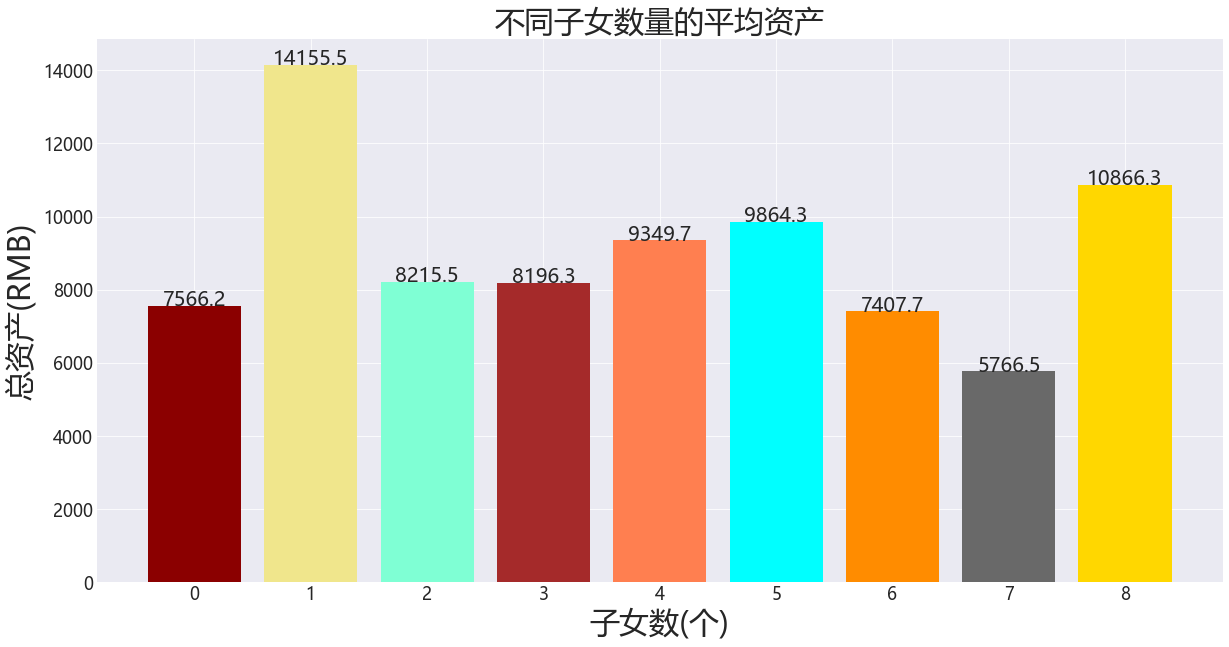

In [93]:
plt.figure(figsize=(20.18,10))
plt.bar(grouped3.child_num_y,grouped3.elderly_asset
        ,color=['#8B0000','#F0E68C','#7FFFD4','#A52A2A','#FF7F50','#00FFFF','#FF8C00','#696969','#FFD700']
       )
plt.title('不同子女数量的平均资产',size=30)
#显示一下具体的数字
for x,y in enumerate(grouped3.elderly_asset):
    plt.text(x,y+3,"%s"%round(y,1),ha='center',size=20)
#设置坐标刻度值的大小
plt.tick_params(labelsize=17)
plt.xlabel("子女数(个)",size=30)
plt.ylabel("总资产(RMB)",size=30)
#下面这行为了解决坐标显示不全的问题
plt.xticks(list(range(0,9,1)))
plt.show()

In [95]:
'''下面这个有些许瑕疵，因为后几项之和，不能和那个总资产完全相等
原因大概是简单求平均造成的，但对于研究规律是够用的
'''

'下面这个有些许瑕疵，因为后几项之和，不能和那个总资产相等\n原因大概是简单求平均造成的，但对于研究规律是够用的\n'

<Figure size 1452.96x1080 with 0 Axes>

<BarContainer object of 9 artists>

<BarContainer object of 9 artists>

<BarContainer object of 9 artists>

<BarContainer object of 9 artists>

Text(0, 0.5, '老年人的资产分布情况(RMB)')

Text(0.5, 0, '子女个数(个)')

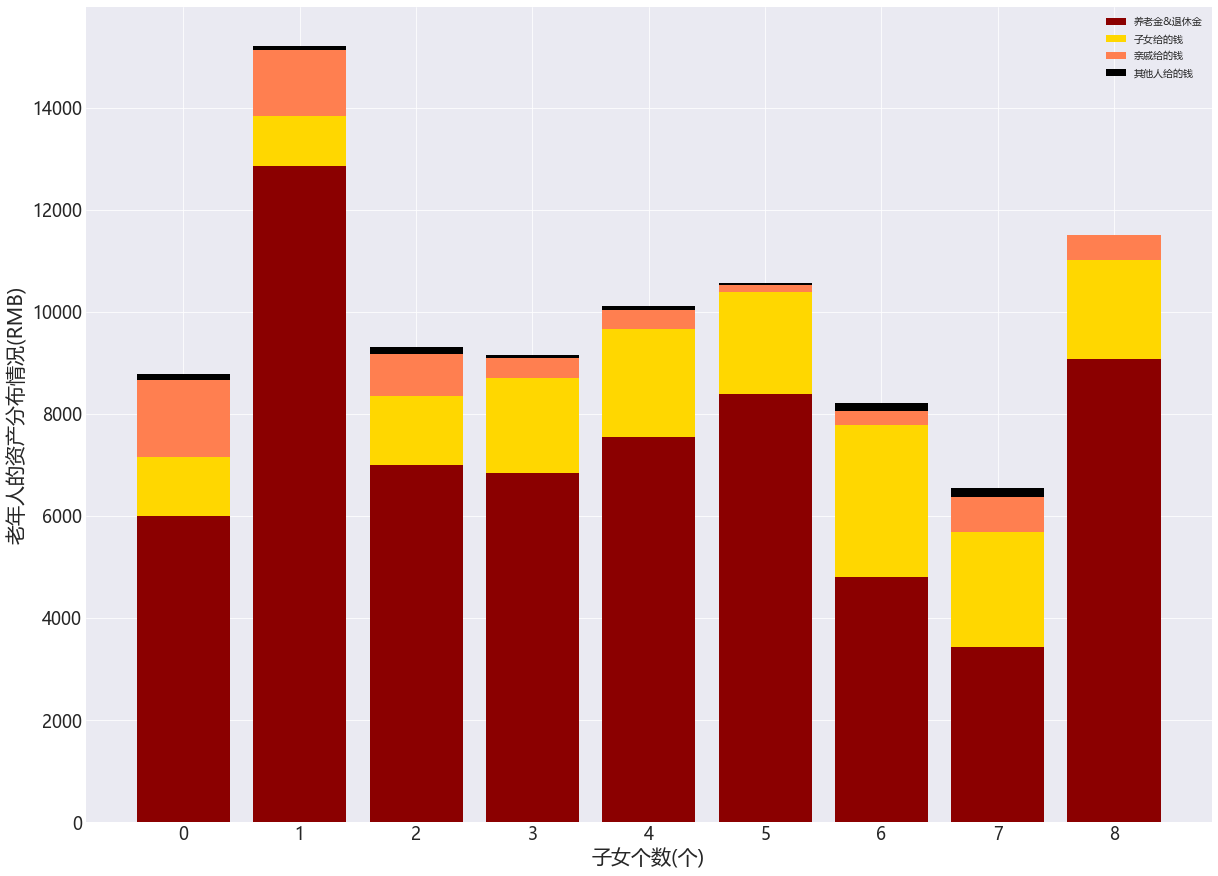

In [113]:
#plt中无法直接画堆叠条形图，只能重复画条形图，然后调整好y的值，合并在一张图上
#取出子女数量作为x轴的标签
child_num=grouped3.child_num_y
#然后分别取出各项资产内容，得到多个dataframe，以及分别重新设置x轴索引
fn301=grouped3.fn301
fn301.index=range(len(child_num))
fn401=grouped3.fn401
fn401.index=range(len(child_num))
fn4=grouped3.fn4
fn4.index=range(len(child_num))
fn5=grouped3.fn5
fn5.index=range(len(child_num))

plt.figure(figsize=(20.18,15))
#接下来画堆叠条形图
plt.bar(x=range(len(child_num)),height=fn301,color='#8B0000',label="养老金&退休金",tick_label=child_num)
plt.bar(x=range(len(child_num)),height=fn401,color='#FFD700',bottom=fn301,label="子女给的钱",tick_label=child_num)
plt.bar(x=range(len(child_num)),height=fn4,color='#FF7F50',bottom=fn401+fn301,label="亲戚给的钱",tick_label=child_num)
plt.bar(x=range(len(child_num)),height=fn5,color='black',bottom=fn4+fn401+fn301,label="其他人给的钱",tick_label=child_num)
plt.ylabel("老年人的资产分布情况(RMB)",size=20)
plt.xlabel("子女个数(个)",size=20)
plt.legend(loc = 'best')
plt.tick_params(labelsize=17)
plt.show()

#很遗憾legend的字体没有调整，比较小。

### 至此子女数维度分析完毕

## 统计家庭成员有身故、病重、意外

- 跨年库
    - alive18：18年是否存活；
    - deathcause_code：死亡原因；
- 个人库
    - qp303：是否病重

In [46]:
#看一些数据分布情况
print(data_cross['alive18'].value_counts()) #0：去世；1：健在；-8：不适用
death=data_cross[data_cross['alive18']==0]
death.loc[:,:].head(5)
print(data_person['qp303'].value_counts()) #1：不严重；3：一般；5：严重；-8：不适用;-1:未知
data_cross.head()
data_person.head()

 1.0    57781
-8.0    15448
 0.0      901
Name: alive18, dtype: int64


,pid,birthy,gender,ethnicity,entrayear,fidbaseline,psu,subsample,subpopulation,fid10,...,cfps2018sch,cfps2018eduy,cfps2018eduy_im,urban18,hk18,employ18,genetype18,coremember18,alive18,releaseversion
290,110060581.0,1912.0,0.0,3.0,2016.0,110060.0,45.0,1.0,6.0,-8.0,...,-9.0,-9.0,-9.0,-8.0,3.0,-8.0,0.0,1.0,0.0,2018.1
328,110074101.0,1948.0,1.0,1.0,2010.0,110074.0,45.0,1.0,6.0,110074.0,...,-9.0,-9.0,-9.0,-8.0,-8.0,-8.0,7.0,-8.0,0.0,2018.1
366,110092102.0,1938.0,0.0,1.0,2010.0,110092.0,45.0,1.0,6.0,110092.0,...,-9.0,-9.0,-9.0,-8.0,-8.0,-8.0,7.0,-8.0,0.0,2018.1
416,110119581.0,1924.0,0.0,NaN,2016.0,110119.0,45.0,1.0,6.0,-8.0,...,1.0,0.0,0.0,-8.0,5.0,-8.0,0.0,0.0,0.0,2018.1
418,110120102.0,1959.0,1.0,1.0,2010.0,110120.0,45.0,1.0,6.0,110120.0,...,-9.0,-9.0,-9.0,-8.0,-8.0,-8.0,7.0,-8.0,0.0,2018.1


-8.0    23630
 3.0     4188
 5.0     3646
 1.0     1628
-1.0        5
Name: qp303, dtype: int64


,pid,birthy,gender,ethnicity,entrayear,fidbaseline,psu,subsample,subpopulation,fid10,...,cfps2018sch,cfps2018eduy,cfps2018eduy_im,urban18,hk18,employ18,genetype18,coremember18,alive18,releaseversion
0,100051501.0,1969.0,0.0,1.0,2014.0,110043.0,45.0,1.0,6.0,-8.0,...,4.0,12.0,12.0,1.0,3.0,1.0,0.0,1.0,1.0,2018.1
1,100051502.0,1966.0,1.0,1.0,2014.0,110043.0,45.0,1.0,6.0,-8.0,...,4.0,12.0,12.0,1.0,3.0,1.0,0.0,1.0,1.0,2018.1
2,100160601.0,1989.0,1.0,1.0,2018.0,120009.0,79.0,1.0,6.0,-8.0,...,-9.0,-9.0,-9.0,1.0,3.0,1.0,0.0,1.0,1.0,2018.1
3,100376551.0,1997.0,0.0,NaN,2016.0,130094.0,47.0,1.0,6.0,-8.0,...,-9.0,-9.0,-9.0,0.0,1.0,3.0,0.0,1.0,1.0,2018.1
4,100435552.0,2016.0,0.0,1.0,2016.0,130155.0,52.0,1.0,6.0,-8.0,...,-9.0,-9.0,-9.0,-8.0,-8.0,-8.0,1.0,-8.0,1.0,2018.1


,pid,code,fid18,fid16,fid14,fid12,fid10,pid_a_f,pid_a_m,selfrpt,...,cfps2018eduy_im,gdge,gdgeyear,gdgemonth,catipilot,pg02,pg1201_min,pg1201_max,interviewerid18,releaseversion
0,100051501.0,501.0,100051.0,100051.0,100051.0,-8.0,-8.0,110043201.0,110043105.0,1.0,...,12.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,761040.0,2.1
1,100051502.0,502.0,100051.0,100051.0,100051.0,-8.0,-8.0,-8.0,-8.0,1.0,...,12.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,761040.0,2.1
2,100160601.0,601.0,100160.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,459505.0,2.1
3,100376551.0,551.0,100376.0,100376.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,526621.0,2.1
4,100551551.0,551.0,100551.0,100551.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,696822.0,2.1


In [47]:
#取出所有有变故的，包括疾病和死亡
seriously_ill=data_person[data_person['qp303']==5]
seriously_ill.loc[:,:]
seriously_ill.append(death,ignore_index=True)

,pid,code,fid18,fid16,fid14,fid12,fid10,pid_a_f,pid_a_m,selfrpt,...,cfps2018eduy_im,gdge,gdgeyear,gdgemonth,catipilot,pg02,pg1201_min,pg1201_max,interviewerid18,releaseversion
7,100810551.0,551.0,100810.0,100810.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,6.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,803368.0,2.1
8,101129501.0,501.0,101129.0,101129.0,101129.0,-8.0,-8.0,-8.0,-8.0,1.0,...,9.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,477664.0,2.1
15,103923551.0,551.0,103923.0,103923.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,707372.0,2.1
54,110026104.0,104.0,110026.0,110026.0,110026.0,110026.0,110026.0,110026204.0,110026205.0,1.0,...,9.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,831811.0,2.1
59,110031101.0,101.0,110031.0,110031.0,110031.0,110031.0,110031.0,110031201.0,110031202.0,1.0,...,12.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,831811.0,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37272,732190501.0,501.0,732190.0,732190.0,732190.0,-8.0,-8.0,-8.0,-8.0,1.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,508549.0,2.1
37281,766521551.0,551.0,766521.0,766521.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,660846.0,2.1
37318,903892431.0,431.0,903892.0,903892.0,903892.0,903892.0,-8.0,903892432.0,903892433.0,1.0,...,12.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,533008.0,2.1
37323,912238554.0,554.0,912238.0,912238.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,605017.0,2.1


,pid,code,fid18,fid16,fid14,fid12,fid10,pid_a_f,pid_a_m,selfrpt,...,inroster18,indsurvey18,selfrpt18,co_a18_p,marriage_18,hk18,employ18,genetype18,coremember18,alive18
0,100810551.0,551.0,100810.0,100810.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101129501.0,501.0,101129.0,101129.0,101129.0,-8.0,-8.0,-8.0,-8.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,103923551.0,551.0,103923.0,103923.0,-8.0,-8.0,-8.0,-8.0,-8.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,110026104.0,104.0,110026.0,110026.0,110026.0,110026.0,110026.0,110026204.0,110026205.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,110031101.0,101.0,110031.0,110031.0,110031.0,110031.0,110031.0,110031201.0,110031202.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4542,621848102.0,NaN,621848.0,621848.0,621848.0,621848.0,621848.0,NaN,NaN,NaN,...,1.0,0.0,-8.0,0.0,2.0,-8.0,-8.0,7.0,-8.0,0.0
4543,621852102.0,NaN,621852.0,621852.0,621852.0,621852.0,621852.0,NaN,NaN,NaN,...,1.0,0.0,-8.0,0.0,2.0,-8.0,-8.0,7.0,-8.0,0.0
4544,621859101.0,NaN,621859.0,621859.0,621859.0,621859.0,621859.0,NaN,NaN,NaN,...,1.0,0.0,-8.0,0.0,2.0,-8.0,-8.0,7.0,-8.0,0.0
4545,723113434.0,NaN,723113.0,-8.0,723113.0,723113.0,-8.0,NaN,NaN,NaN,...,1.0,0.0,-8.0,0.0,5.0,1.0,-8.0,0.0,0.0,0.0


In [66]:
#在资产表中取出所有有变故的和没变故的
famecon.reset_index(inplace=True)
df_new=famecon[famecon['fid18'].isin(seriously_ill['fid18'])]
df_new1=famecon[~famecon['fid18'].isin(seriously_ill['fid18'])]

In [67]:
#赋值，有变故的赋值为yes，反之为no
df_new['is']='有变故'
df_new1['is']='无变故'
df_new=df_new[['fid18','is']]
df_new1=df_new1[['fid18','is']]
#然后把有无变故的两个表拼在一起
df_new=pd.concat([df_new,df_new1])
df_new

,fid18,is
12,100810.0,有变故
15,101023.0,有变故
16,101129.0,有变故
18,101274.0,有变故
27,102730.0,有变故
...,...,...
14213,6609501.0,无变故
14214,6646971.0,无变故
14215,6694541.0,无变故
14216,6704011.0,无变故


In [68]:
f2=pd.merge(left=famecon,right=df_new,on='fid18')
f2['is'].describe()

count     14218
unique        2
top         无变故
freq      11089
Name: is, dtype: object

In [69]:
result1 = merge1[['housing','durable','fin_asset','mortgage','bank_loan','friend_loan']].groupby(f2['is']).agg(lambda x: sum(x)/len(x))

In [70]:
# result1.reset_index(inplace=True)
result1

,housing,durable,fin_asset,mortgage,bank_loan,friend_loan
is,,,,,,
无变故,0.830463,0.909279,0.061773,0.119668,0.095500,0.113897
有变故,0.897411,0.911793,0.039949,0.107063,0.098434,0.182486


Text(0.5, 0, 'participation rate')

Text(0, 0.5, '是否有变故')

Text(0.5, 0, 'participation rate')

Text(0, 0.5, '是否有变故')

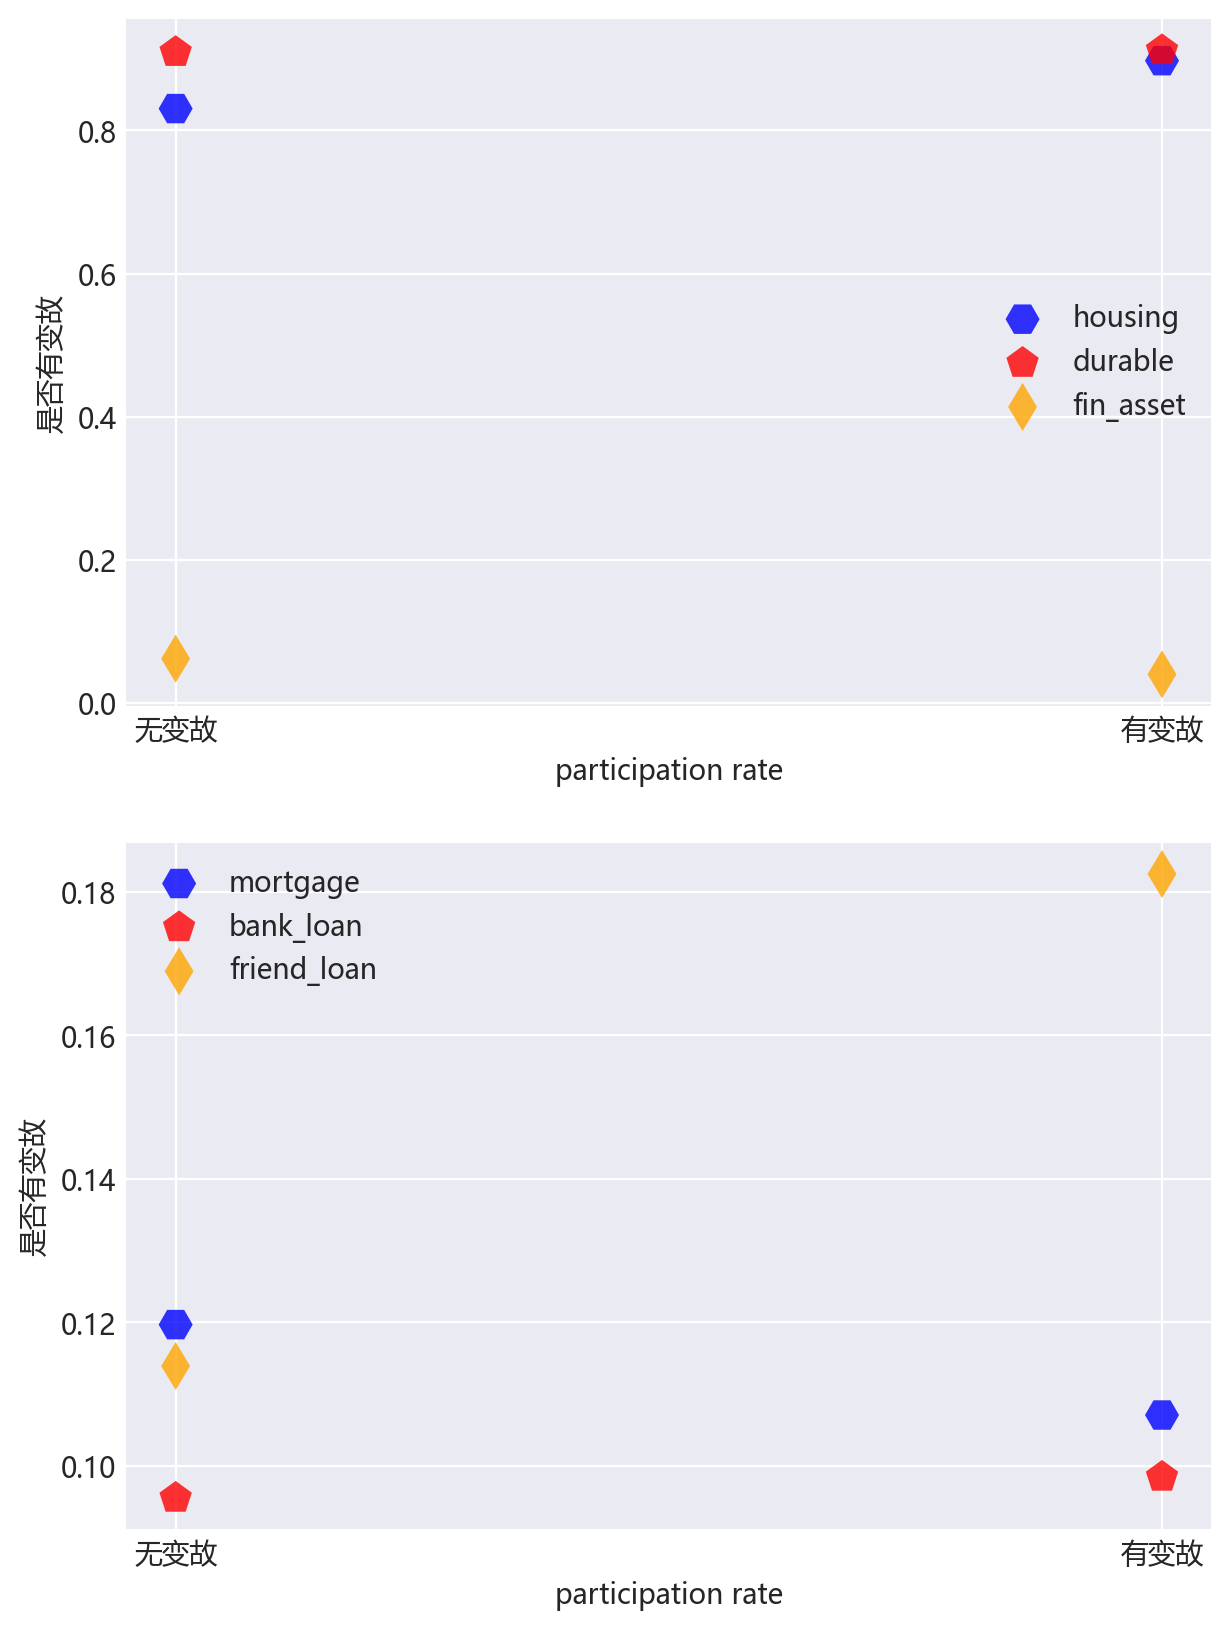

In [71]:
colors = ['blue','red','orange']
markers = ['H','p','d']
fig = plt.figure(figsize=(7,10),dpi=200)
plt.style.use('seaborn-darkgrid')#指定风格,ggplot太丑了
for j in [1,2]:
    ax = fig.add_subplot(2,1,j)
    for i in range(3):
        ax.scatter(result1.index[0:9],#传入数据x
                   result1.iloc[0:9,(j-1)*3+i],#传入数据y
                    s = 150,#散点图形（marker）的大小
                    c = colors[i],#marker颜色
                    marker = markers[i],#marker形状
                    #marker=matplotlib.markers.MarkerStyle(marker = markers[i],fillstyle='full'),#设置marker的填充
                    alpha=0.8,#marker透明度，范围为0-1
                    facecolors='r',#marker的填充颜色，当上面c参数设置了颜色，优先c
                    edgecolors='none',#marker的边缘线色
                    linewidths=1,#marker边缘线宽度，edgecolors不设置时，该参数不起作用
                    label = result.columns[(j-1)*3+i])#后面图例的名称取自label
                 
 
    plt.legend(loc = 'best')
    plt.xlabel('participation rate')
    plt.ylabel("是否有变故")
#字体设为微软雅黑
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.show()
# plt.savefig('ages.png')

## 散点图不利于观察，通过条形图来进行对比

<AxesSubplot:xlabel='is'>

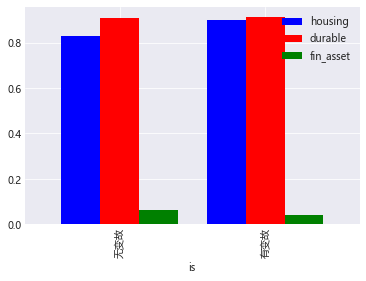

In [73]:
result1.reset_index(inplace=True)
result1.plot(x='is',y=['housing','durable','fin_asset'],kind='bar',
             color=['blue','red','green'],width=0.8)

<AxesSubplot:xlabel='is'>

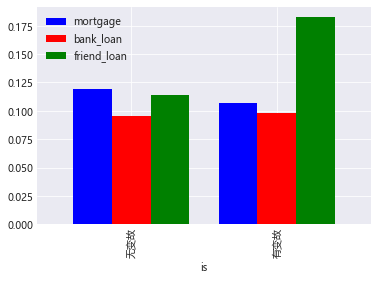

In [74]:
result1.plot(x='is',y=['mortgage','bank_loan','friend_loan'],kind='bar',
             color=['blue','red','green'],width=0.8)

## 至此是否有变故的分析也完成了